In [43]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score, accuracy_score


from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt

# ELO Model

In [9]:
elo_reformat = pd.read_csv('/Users/Tim/Downloads/elo_reformat.csv')

In [10]:
elo_reformat["ELO_x"]= 1500
elo_reformat["ELO_y"]= 1500

abr = list(elo_reformat.TEAM_ABBREVIATION_x.unique())

In [237]:
def calc_elo(data, k, m=True):
    
    ## home court + 100

    ## k = k * (MOV + 3)^0.8 / (7.5 + 0.006 * (elo won - elo lost))

    ## new season = (old*.75) + (1505*0.25)

    ## e = 1 / (1 + 10^((rating opp - rating)/400))

    ## new elo (win) = old elo + k (1 - e)

    elos = {}

    for i in abr:
        elos[i]=1500

    data["ELO_x"]= 1500
    data["ELO_y"]= 1500

    season = data["SEASON_ID_x"][0]

    for i in range(len(data)):
        if data["SEASON_ID_x"][i] != season:
            season = data["SEASON_ID_x"][i]
            for team in elos:
                elos[team] = (0.75*elos[team]) + (0.25 * 1505)

        if data['WL_x'][i] == 1:
            data.loc[i,'ELO_x'] = elos[data['TEAM_ABBREVIATION_x'][i]] + 100
            data.loc[i,'ELO_y'] = elos[data['TEAM_ABBREVIATION_y'][i]]
            
            if m == True:
                MOV = k*((data['PLUS_MINUS_x'][i]+3)**(0.8)/ (7.5 + 0.006*(data['ELO_x'][i]-data['ELO_y'][i])))
            else:
                MOV=k
            E_H = 1/(1+10**((data['ELO_y'][i]-data['ELO_x'][i])/400))

            change = MOV * (1-E_H)


            eloH_new = elos[data['TEAM_ABBREVIATION_x'][i]] + change
            eloA_new = elos[data['TEAM_ABBREVIATION_y'][i]] - change

            elos[data['TEAM_ABBREVIATION_x'][i]] = eloH_new
            elos[data['TEAM_ABBREVIATION_y'][i]] = eloA_new

        else:
            data.loc[i,'ELO_x'] = elos[data['TEAM_ABBREVIATION_x'][i]] + 100
            data.loc[i,'ELO_y'] = elos[data['TEAM_ABBREVIATION_y'][i]]
            
            if m == True:
                MOV = k*((data['PLUS_MINUS_y'][i]+3)**(0.8)/ (7.5 + 0.006*(data['ELO_y'][i]-data['ELO_x'][i])))
            else:
                MOV=1
            E_A = 1/(1+10**((data['ELO_x'][i]-data['ELO_y'][i])/400))

            change = MOV * (1-E_A)

            eloH_new = elos[data['TEAM_ABBREVIATION_x'][i]] - change
            eloA_new = elos[data['TEAM_ABBREVIATION_y'][i]] + change

            elos[data['TEAM_ABBREVIATION_x'][i]] = eloH_new
            elos[data['TEAM_ABBREVIATION_y'][i]] = eloA_new
    return data

        

### No margin of victory

In [4]:
elos = {}

for i in abr:
    elos[i]=1500

In [257]:
## home court + 100

## k = k * (MOV + 3)^0.8 / (7.5 + 0.006 * (elo won - elo lost))

## new season = (old*.75) + (1505*0.25)

## e = 1 / (1 + 10^((rating opp - rating)/400))

## new elo (win) = old elo + k (1 - e)

accs2 = []

for k in range(1,51):

    elos = {}

    for i in abr:
        elos[i]=1500

    elo_reformat["ELO_x"]= 1500
    elo_reformat["ELO_y"]= 1500

    season = elo_reformat["SEASON_ID_x"][0]
    maxC = 0
    maxG = 0 

    correct = 0

    for i in range(len(elo_reformat)):
        if elo_reformat["SEASON_ID_x"][i] != season:
            season = elo_reformat["SEASON_ID_x"][i]
            for team in elos:
                elos[team] = (0.75*elos[team]) + (0.25 * 1505)

        if elo_reformat['WL_x'][i] == 1:
            elo_reformat.loc[i,'ELO_x'] = elos[elo_reformat['TEAM_ABBREVIATION_x'][i]] + 100
            elo_reformat.loc[i,'ELO_y'] = elos[elo_reformat['TEAM_ABBREVIATION_y'][i]]

            E_H = 1/(1+10**((elo_reformat['ELO_y'][i]-elo_reformat['ELO_x'][i])/400))

            change = k * (1-E_H)
            if change > maxC:
                maxC = change
                maxG = i

            if elo_reformat['ELO_x'][i] > elo_reformat['ELO_y'][i]:
                correct +=1

            eloH_new = elos[elo_reformat['TEAM_ABBREVIATION_x'][i]] + change
            eloA_new = elos[elo_reformat['TEAM_ABBREVIATION_y'][i]] - change

            elos[elo_reformat['TEAM_ABBREVIATION_x'][i]] = eloH_new
            elos[elo_reformat['TEAM_ABBREVIATION_y'][i]] = eloA_new

        else:
            elo_reformat.loc[i,'ELO_x'] = elos[elo_reformat['TEAM_ABBREVIATION_x'][i]] + 100
            elo_reformat.loc[i,'ELO_y'] = elos[elo_reformat['TEAM_ABBREVIATION_y'][i]]

            #MOV = k*((elo_reformat['PLUS_MINUS_y'][i]+3)**(0.8)/ (7.5 + 0.006*(elo_reformat['ELO_y'][i]-elo_reformat['ELO_x'][i])))
            E_A = 1/(1+10**((elo_reformat['ELO_x'][i]-elo_reformat['ELO_y'][i])/400))

            change = k * (1-E_A)

            if change > maxC:
                maxC = change
                maxG = i

            if elo_reformat['ELO_y'][i] > elo_reformat['ELO_x'][i]:
                correct +=1


            eloH_new = elos[elo_reformat['TEAM_ABBREVIATION_x'][i]] - change
            eloA_new = elos[elo_reformat['TEAM_ABBREVIATION_y'][i]] + change

            elos[elo_reformat['TEAM_ABBREVIATION_x'][i]] = eloH_new
            elos[elo_reformat['TEAM_ABBREVIATION_y'][i]] = eloA_new
    accs2.append(correct/len(elo_reformat))
        

In [183]:
max(accs2)

0.6701629154830407

In [259]:
for i in range(len(accs2)):
    if accs2[i]==max(accs2):
        print("K =",i)

K = 35


In [254]:
temp = calc_elo(elo_reformat, 35, m=False)

In [255]:
tp = 0
fp = 0
fn = 0
probs = []
for i in range(len(temp)):
    if temp['ELO_x'][i]>=temp['ELO_y'][i]:
        if temp['WL_x'][i]==1:
            tp+=1
        else:
            fp+=1
    elif temp['WL_x'][i]==1:
        fn+=1
    E_H = 1/(1+10**((elo_reformat['ELO_y'][i]-elo_reformat['ELO_x'][i])/400))
    probs.append(E_H)

In [263]:
precision = (tp)/(tp+fp)
print("Precision:",precision)

recall = (tp)/(tp+fn)
print("Recall:", recall)

f1 = (2*precision*recall)/(precision+recall)
print("F1 score:", f1)

auc = roc_auc_score(temp['WL_x'], probs)
print("AUC:", auc)

Precision: 0.6490667127549257
Recall: 0.9142289122408407
F1 score: 0.7591597459697118
AUC: 0.7049444283880901


### With margin of victory

In [182]:
## home court + 100

## k = k * (MOV + 3)^0.8 / (7.5 + 0.006 * (elo won - elo lost))

## new season = (old*.75) + (1505*0.25)

## e = 1 / (1 + 10^((rating opp - rating)/400))

## new elo (win) = old elo + k (1 - e)

accs = []

for k in range(1,41):

    elos = {}

    for i in abr:
        elos[i]=1500

    elo_reformat["ELO_x"]= 1500
    elo_reformat["ELO_y"]= 1500

    season = elo_reformat["SEASON_ID_x"][0]
    maxC = 0
    maxG = 0 

    correct = 0

    for i in range(len(elo_reformat)):
        if elo_reformat["SEASON_ID_x"][i] != season:
            season = elo_reformat["SEASON_ID_x"][i]
            for team in elos:
                elos[team] = (0.75*elos[team]) + (0.25 * 1505)

        if elo_reformat['WL_x'][i] == 1:
            elo_reformat.loc[i,'ELO_x'] = elos[elo_reformat['TEAM_ABBREVIATION_x'][i]] + 100
            elo_reformat.loc[i,'ELO_y'] = elos[elo_reformat['TEAM_ABBREVIATION_y'][i]]

            MOV = k*((elo_reformat['PLUS_MINUS_x'][i]+3)**(0.8)/ (7.5 + 0.006*(elo_reformat['ELO_x'][i]-elo_reformat['ELO_y'][i])))
            E_H = 1/(1+10**((elo_reformat['ELO_y'][i]-elo_reformat['ELO_x'][i])/400))

            change = MOV * (1-E_H)
            if change > maxC:
                maxC = change
                maxG = i

            if elo_reformat['ELO_x'][i] > elo_reformat['ELO_y'][i]:
                correct +=1

            eloH_new = elos[elo_reformat['TEAM_ABBREVIATION_x'][i]] + change
            eloA_new = elos[elo_reformat['TEAM_ABBREVIATION_y'][i]] - change

            elos[elo_reformat['TEAM_ABBREVIATION_x'][i]] = eloH_new
            elos[elo_reformat['TEAM_ABBREVIATION_y'][i]] = eloA_new

        else:
            elo_reformat.loc[i,'ELO_x'] = elos[elo_reformat['TEAM_ABBREVIATION_x'][i]] + 100
            elo_reformat.loc[i,'ELO_y'] = elos[elo_reformat['TEAM_ABBREVIATION_y'][i]]

            MOV = k*((elo_reformat['PLUS_MINUS_y'][i]+3)**(0.8)/ (7.5 + 0.006*(elo_reformat['ELO_y'][i]-elo_reformat['ELO_x'][i])))
            E_A = 1/(1+10**((elo_reformat['ELO_x'][i]-elo_reformat['ELO_y'][i])/400))

            change = MOV * (1-E_A)

            if change > maxC:
                maxC = change
                maxG = i

            if elo_reformat['ELO_y'][i] > elo_reformat['ELO_x'][i]:
                correct +=1


            eloH_new = elos[elo_reformat['TEAM_ABBREVIATION_x'][i]] - change
            eloA_new = elos[elo_reformat['TEAM_ABBREVIATION_y'][i]] + change

            elos[elo_reformat['TEAM_ABBREVIATION_x'][i]] = eloH_new
            elos[elo_reformat['TEAM_ABBREVIATION_y'][i]] = eloA_new
    accs.append(correct/len(elo_reformat))
        

In [28]:
max(accs)

0.6714740087891811

In [190]:
for i in range(len(accs)):
    if accs[i]==max(accs):
        print(i)

21
27
29


In [264]:
temp = calc_elo(elo_reformat, 27, True)

In [265]:
tp = 0
fp = 0
fn = 0
probs = []
for i in range(len(temp)):
    if temp['ELO_x'][i]>=temp['ELO_y'][i]:
        if temp['WL_x'][i]==1:
            tp+=1
        else:
            fp+=1
    elif temp['WL_x'][i]==1:
        fn+=1
    E_H = 1/(1+10**((elo_reformat['ELO_y'][i]-elo_reformat['ELO_x'][i])/400))
    probs.append(E_H)

In [266]:
precision = (tp)/(tp+fp)
print("Precision:",precision)

recall = (tp)/(tp+fn)
print("Recall:", recall)

f1 = (2*precision*recall)/(precision+recall)
print("F1 score:", f1)

auc = roc_auc_score(temp['WL_x'], probs)
print("AUC:", auc)

Precision: 0.6810077898373587
Recall: 0.8477299468495152
F1 score: 0.7552776171197224
AUC: 0.7147470628686976


# ML Models Train/Test datasets

In [11]:
sliding = pd.read_csv("/Users/Tim/Downloads/sliding_window_50.csv").sort_values(by='GAME_DATE_x').reset_index(drop=True)
ewma = pd.read_csv("/Users/Tim/Downloads/ewma_7.csv").sort_values(by='GAME_DATE_x').reset_index(drop=True)

In [12]:
sliding_train = sliding[:5646]
sliding_test = sliding[5646:]

ewma_train = ewma[:5646]
ewma_test = ewma[5646:]

In [13]:
sliding

,Unnamed: 0,SEASON_ID_x,TEAM_ID_x,TEAM_ABBREVIATION_x,TEAM_NAME_x,GAME_ID,GAME_DATE_x,MATCHUP_x,WL_x,PLAYOFF_IND_x,...,NET_REB_PCT_opp,NET_TM_TOV_PCT_opp,NET_EFG_PCT_opp,NET_TS_PCT_opp,NET_PIE_opp,NET_HOME,NET_WIN_PERC,NET_FTA_opp,NET_KEY_DNP_opp,NET_GAMES_PLAYED_7
0,0,22017,1610612742,DAL,Dallas Mavericks,21700024,2017-10-20,DAL vs. SAC,0,0,...,0.04600,-3.500,0.08900,0.03400,0.01100,1,0.00,-8,0,0
1,1,22017,1610612750,MIN,Minnesota Timberwolves,21700023,2017-10-20,MIN vs. UTA,1,0,...,0.05000,-10.100,-0.04600,-0.03300,0.13900,1,-1.00,-9,0,0
2,2,22017,1610612756,PHX,Phoenix Suns,21700026,2017-10-20,PHX vs. LAL,0,0,...,0.07100,3.600,0.11800,0.12700,0.27100,1,0.00,-5,0,0
3,3,22017,1610612740,NOP,New Orleans Pelicans,21700025,2017-10-20,NOP vs. GSW,0,0,...,-0.03900,-0.500,-0.08900,-0.08500,0.05800,1,0.00,-2,0,0
4,4,22017,1610612751,BKN,Brooklyn Nets,21700022,2017-10-20,BKN vs. ORL,1,0,...,0.03300,-0.400,0.08900,0.10100,0.11300,1,-1.00,-20,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7524,7524,42022,1610612752,NYK,New York Knicks,42200205,2023-05-10,NYK vs. MIA,1,1,...,-0.01864,-2.588,-0.01938,-0.01356,-0.00332,1,0.00,-21,0,0
7525,7525,42022,1610612755,PHI,Philadelphia 76ers,42200216,2023-05-11,PHI vs. BOS,0,1,...,-0.00792,1.132,0.02620,0.02890,0.00526,1,0.08,-3,1,0
7526,7526,42022,1610612756,PHX,Phoenix Suns,42200226,2023-05-11,PHX vs. DEN,0,1,...,0.00958,0.072,-0.00310,0.00082,0.00756,1,-0.02,11,0,0
7527,7527,42022,1610612748,MIA,Miami Heat,42200206,2023-05-12,MIA vs. NYK,1,1,...,0.01958,2.606,0.02142,0.01582,0.00570,1,-0.02,7,0,0


In [14]:
## Adding net elo as a variable

temp = calc_elo(elo_reformat, 27, True)

In [15]:
temp = temp.drop(columns = ['Unnamed: 0', 'SEASON_ID_x', 'TEAM_ID_x', 'TEAM_ABBREVIATION_x',
       'TEAM_NAME_x', 'GAME_DATE_x', 'MATCHUP_x', 'WL_x', 'PTS_x',
       'PLUS_MINUS_x', 'HOME_x', 'SEASON_ID_y', 'TEAM_ID_y',
       'TEAM_ABBREVIATION_y', 'TEAM_NAME_y', 'GAME_DATE_y', 'MATCHUP_y',
       'WL_y', 'PTS_y', 'PLUS_MINUS_y', 'HOME_y'])
temp['NET_ELO'] = temp['ELO_x']-temp['ELO_y']
temp = temp.drop(columns = ['ELO_x', 'ELO_y'])

In [16]:
temp

,GAME_ID,NET_ELO
0,29000008,100.000000
1,29000010,100.000000
2,29000012,100.000000
3,29000005,100.000000
4,29000011,100.000000
...,...,...
41182,42200205,66.104833
41183,42200216,89.281583
41184,42200226,86.258213
41185,42200236,115.184821


In [17]:
ewma_test

,Unnamed: 0,SEASON_ID_x,TEAM_ID_x,TEAM_ABBREVIATION_x,TEAM_NAME_x,GAME_ID,GAME_DATE_x,MATCHUP_x,WL_x,PLAYOFF_IND_x,...,NET_REB_PCT_opp,NET_TM_TOV_PCT_opp,NET_EFG_PCT_opp,NET_TS_PCT_opp,NET_PIE_opp,NET_HOME,NET_WIN_PERC,NET_FTA_opp,NET_KEY_DNP_opp,NET_GAMES_PLAYED_7
5646,5643,22021,1610612759,SAS,San Antonio Spurs,22100742,2022-01-28,SAS vs. CHI,1,0,...,0.016231,0.239467,-0.007158,-0.013068,-0.017340,1,-0.178555,8,0,0
5647,5640,22021,1610612753,ORL,Orlando Magic,22100736,2022-01-28,ORL vs. DET,1,0,...,-0.010585,-0.155051,0.014140,0.008239,0.002874,1,-0.024851,11,0,0
5648,5644,22021,1610612760,OKC,Oklahoma City Thunder,22100741,2022-01-28,OKC vs. IND,0,0,...,0.023663,0.028806,-0.015683,-0.021211,0.019719,1,-0.095774,12,0,0
5649,5642,22021,1610612737,ATL,Atlanta Hawks,22100737,2022-01-28,ATL vs. BOS,1,0,...,0.000216,-1.886785,0.026432,0.021696,-0.001236,1,0.195521,7,0,0
5650,5641,22021,1610612749,MIL,Milwaukee Bucks,22100744,2022-01-28,MIL vs. NYK,1,0,...,0.005372,-0.089436,-0.006304,-0.009728,-0.023921,1,0.057749,-3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7524,7524,42022,1610612752,NYK,New York Knicks,42200205,2023-05-10,NYK vs. MIA,1,1,...,-0.026520,-1.781432,-0.012197,-0.015299,-0.018158,1,0.063518,-21,0,0
7525,7525,42022,1610612755,PHI,Philadelphia 76ers,42200216,2023-05-11,PHI vs. BOS,0,1,...,-0.008736,1.066059,0.011796,0.015883,0.018594,1,0.137630,-3,1,0
7526,7526,42022,1610612756,PHX,Phoenix Suns,42200226,2023-05-11,PHX vs. DEN,0,1,...,0.035233,0.952424,-0.005324,0.001556,0.013947,1,-0.043136,11,0,0
7527,7527,42022,1610612748,MIA,Miami Heat,42200206,2023-05-12,MIA vs. NYK,1,1,...,0.034029,2.481872,0.024516,0.013332,-0.008151,1,0.073829,7,0,0


In [18]:
sliding_train = pd.merge(sliding_train, temp, how="inner", left_on=['GAME_ID'], right_on = ['GAME_ID'])
sliding_test = pd.merge(sliding_test, temp, how="inner", left_on=['GAME_ID'], right_on = ['GAME_ID'])

ewma_train = pd.merge(ewma_train, temp, how="inner", left_on=['GAME_ID'], right_on = ['GAME_ID'])
ewma_test = pd.merge(ewma_test, temp, how="inner", left_on=['GAME_ID'], right_on = ['GAME_ID'])

In [19]:
sliding_train.columns

Index(['Unnamed: 0', 'SEASON_ID_x', 'TEAM_ID_x', 'TEAM_ABBREVIATION_x',
       'TEAM_NAME_x', 'GAME_ID', 'GAME_DATE_x', 'MATCHUP_x', 'WL_x',
       'PLAYOFF_IND_x', 'GAME_NUMBER_opp_x', 'BACK_BACK_x', 'REST_x',
       'SEASON_ID_y', 'TEAM_ID_y', 'TEAM_ABBREVIATION_y', 'TEAM_NAME_y',
       'GAME_DATE_y', 'MATCHUP_y', 'WL_y', 'PLAYOFF_IND_y',
       'GAME_NUMBER_opp_y', 'BACK_BACK_y', 'REST_y', 'NET_MIN', 'NET_PTS',
       'NET_FGM', 'NET_FGA', 'NET_FG_PCT', 'NET_FG3M', 'NET_FG3A',
       'NET_FG3_PCT', 'NET_FTM', 'NET_FTA', 'NET_FT_PCT', 'NET_OREB',
       'NET_DREB', 'NET_REB', 'NET_AST', 'NET_STL', 'NET_BLK', 'NET_TOV',
       'NET_PF', 'NET_PLUS_MINUS', 'NET_OFF_RATING', 'NET_DEF_RATING',
       'NET_NET_RATING', 'NET_AST_PCT', 'NET_AST_TOV', 'NET_AST_RATIO',
       'NET_OREB_PCT', 'NET_DREB_PCT', 'NET_REB_PCT', 'NET_TM_TOV_PCT',
       'NET_EFG_PCT', 'NET_TS_PCT', 'NET_PACE', 'NET_PACE_PER40', 'NET_POSS',
       'NET_PIE', 'NET_KEY_DNP', 'NET_GAME_NUMBER', 'NET_PTS_opp',
       'NE

In [20]:
drop = ['Unnamed: 0', 'SEASON_ID_x', 'TEAM_ID_x',
       'TEAM_ABBREVIATION_x', 'TEAM_NAME_x', 'GAME_ID', 'GAME_DATE_x',
       'MATCHUP_x','GAME_NUMBER_opp_x', 'SEASON_ID_y', 'TEAM_ID_y',
       'TEAM_ABBREVIATION_y', 'TEAM_NAME_y', 'GAME_DATE_y', 'MATCHUP_y',
       'WL_y', 'PLAYOFF_IND_y', 'GAME_NUMBER_opp_y','NET_HOME']

In [21]:
sliding_train = sliding_train.drop(columns=drop)
sliding_test = sliding_test.drop(columns=drop)

ewma_train = ewma_train.drop(columns=drop)
ewma_test = ewma_test.drop(columns=drop)

In [22]:
sliding_train_y = sliding_train['WL_x']
sliding_test_y = sliding_test['WL_x']

sliding_train_x = sliding_train.drop(columns=['WL_x'])
sliding_test_x = sliding_test.drop(columns=['WL_x'])

ewma_train_y = ewma_train['WL_x']
ewma_test_y = ewma_test['WL_x']

ewma_train_x = ewma_train.drop(columns=['WL_x'])
ewma_test_x = ewma_test.drop(columns=['WL_x'])

In [23]:
over_sampler = RandomOverSampler(random_state=42)
sliding_train_bal_x, sliding_train_bal_y = over_sampler.fit_resample(sliding_train_x, sliding_train_y)
ewma_train_bal_x, ewma_train_bal_y = over_sampler.fit_resample(ewma_train_x, ewma_train_y)

In [449]:
ewma_test_x.to_csv("ewma_test_x.csv")

In [24]:
scaler = StandardScaler()
sliding_train_bal_x_scale = scaler.fit_transform(sliding_train_bal_x)
sliding_test_x_scale = scaler.transform(sliding_test_x)

scaler = StandardScaler()
ewma_train_bal_x_scale = scaler.fit_transform(ewma_train_bal_x)
ewma_test_x_scale = scaler.transform(ewma_test_x)

# Feature Selection

using SelectKBest to get best feature set to use for all models in order to use consistent dataset to properly compare models

In [25]:
def findK(X, y):

    ks = [x for x in range(1, 71)]

    accs = []

    best = 0
    bestk = 0

    for k in ks:
        selector = SelectKBest(score_func=f_classif, k=k)
        x = selector.fit_transform(X, y)

        model = LogisticRegression()


        acc = cross_val_score(model, x, y, cv=10)
        temp = acc.mean()

        accs.append(temp)

        if temp > best:
            best = temp
            bestk = k



    for i in range(len(ks)):
        print(f"k = {ks[i]}: Accuracy = {accs[i]:.4f}")

    print("Best k:", bestk)
    
    plt.plot(ks, accs)
    plt.xlabel('k')
    plt.ylabel('Accuracy')



/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

k = 1: Accuracy = 0.6293
k = 2: Accuracy = 0.6313
k = 3: Accuracy = 0.6313
k = 4: Accuracy = 0.6305
k = 5: Accuracy = 0.6318
k = 6: Accuracy = 0.6322
k = 7: Accuracy = 0.6321
k = 8: Accuracy = 0.6318
k = 9: Accuracy = 0.6319
k = 10: Accuracy = 0.6319
k = 11: Accuracy = 0.6313
k = 12: Accuracy = 0.6327
k = 13: Accuracy = 0.6316
k = 14: Accuracy = 0.6313
k = 15: Accuracy = 0.6321
k = 16: Accuracy = 0.6316
k = 17: Accuracy = 0.6319
k = 18: Accuracy = 0.6322
k = 19: Accuracy = 0.6327
k = 20: Accuracy = 0.6307
k = 21: Accuracy = 0.6330
k = 22: Accuracy = 0.6332
k = 23: Accuracy = 0.6321
k = 24: Accuracy = 0.6322
k = 25: Accuracy = 0.6332
k = 26: Accuracy = 0.6321
k = 27: Accuracy = 0.6393
k = 28: Accuracy = 0.6393
k = 29: Accuracy = 0.6396
k = 30: Accuracy = 0.6365
k = 31: Accuracy = 0.6383
k = 32: Accuracy = 0.6374
k = 33: Accuracy = 0.6383
k = 34: Accuracy = 0.6390
k = 35: Accuracy = 0.6366
k = 36: Accuracy = 0.6368
k = 37: Accuracy = 0.6357
k = 38: Accuracy = 0.6372
k = 39: Accuracy = 0.

/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


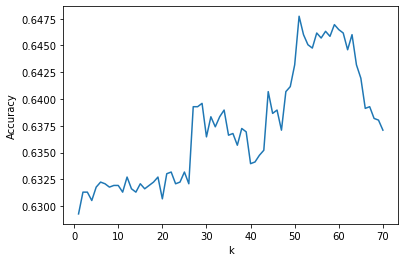

In [187]:
findK(sliding_train_bal_x, sliding_train_bal_y)

In [138]:
selector = SelectKBest(score_func=f_classif, k=51)
sliding_train_bal_x_feat = selector.fit_transform(sliding_train_bal_x, sliding_train_bal_y)
sliding_test_x_feat = selector.transform(sliding_test_x)

sliding_train_bal_x_feat_cols = []

for i in range(70):
    if selector.get_support()[i]==True:
        print(sliding_train_bal_x.columns[i])
        sliding_train_bal_x_feat_cols.append(sliding_train_bal_x.columns[i])
        
        
print("")
print('NOT INCLUDED:')

for i in range(70):
    if selector.get_support()[i]==False:
        print(sliding_train_bal_x.columns[i])

BACK_BACK_y
NET_PTS
NET_FGM
NET_FG_PCT
NET_FG3M
NET_FG3A
NET_FG3_PCT
NET_FTM
NET_FT_PCT
NET_DREB
NET_REB
NET_AST
NET_STL
NET_BLK
NET_TOV
NET_PLUS_MINUS
NET_OFF_RATING
NET_DEF_RATING
NET_NET_RATING
NET_AST_PCT
NET_AST_TOV
NET_AST_RATIO
NET_DREB_PCT
NET_REB_PCT
NET_TM_TOV_PCT
NET_EFG_PCT
NET_TS_PCT
NET_PIE
NET_KEY_DNP
NET_PTS_opp
NET_FG_PCT_opp
NET_FG3M_opp
NET_FG3_PCT_opp
NET_OREB_opp
NET_DREB_opp
NET_REB_opp
NET_STL_opp
NET_BLK_opp
NET_OFF_RATING_opp
NET_DEF_RATING_opp
NET_NET_RATING_opp
NET_OREB_PCT_opp
NET_REB_PCT_opp
NET_EFG_PCT_opp
NET_TS_PCT_opp
NET_PIE_opp
NET_WIN_PERC
NET_FTA_opp
NET_KEY_DNP_opp
NET_GAMES_PLAYED_7
NET_ELO

NOT INCLUDED:
PLAYOFF_IND_x
BACK_BACK_x
REST_x
REST_y
NET_MIN
NET_FGA
NET_FTA
NET_OREB
NET_PF
NET_OREB_PCT
NET_PACE
NET_PACE_PER40
NET_POSS
NET_GAME_NUMBER
NET_FG3A_opp
NET_TOV_opp
NET_PF_opp
NET_DREB_PCT_opp
NET_TM_TOV_PCT_opp


/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

k = 1: Accuracy = 0.6293
k = 2: Accuracy = 0.6311
k = 3: Accuracy = 0.6313
k = 4: Accuracy = 0.6308
k = 5: Accuracy = 0.6321
k = 6: Accuracy = 0.6340
k = 7: Accuracy = 0.6340
k = 8: Accuracy = 0.6343
k = 9: Accuracy = 0.6343
k = 10: Accuracy = 0.6330
k = 11: Accuracy = 0.6333
k = 12: Accuracy = 0.6335
k = 13: Accuracy = 0.6333
k = 14: Accuracy = 0.6335
k = 15: Accuracy = 0.6315
k = 16: Accuracy = 0.6324
k = 17: Accuracy = 0.6308
k = 18: Accuracy = 0.6304
k = 19: Accuracy = 0.6305
k = 20: Accuracy = 0.6324
k = 21: Accuracy = 0.6308
k = 22: Accuracy = 0.6315
k = 23: Accuracy = 0.6310
k = 24: Accuracy = 0.6326
k = 25: Accuracy = 0.6330
k = 26: Accuracy = 0.6333
k = 27: Accuracy = 0.6365
k = 28: Accuracy = 0.6352
k = 29: Accuracy = 0.6352
k = 30: Accuracy = 0.6344
k = 31: Accuracy = 0.6341
k = 32: Accuracy = 0.6355
k = 33: Accuracy = 0.6360
k = 34: Accuracy = 0.6351
k = 35: Accuracy = 0.6340
k = 36: Accuracy = 0.6341
k = 37: Accuracy = 0.6360
k = 38: Accuracy = 0.6358
k = 39: Accuracy = 0.

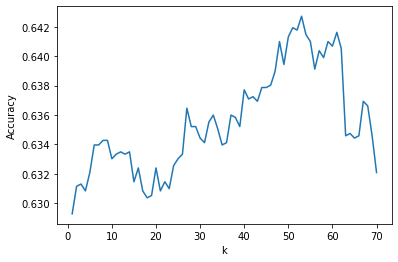

In [193]:
findK(sliding_train_bal_x_scale, sliding_train_bal_y)

In [143]:
selector = SelectKBest(score_func=f_classif, k=53)
sliding_train_bal_x_scale_feat = selector.fit_transform(sliding_train_bal_x_scale, sliding_train_bal_y)
sliding_test_x_scale_feat = selector.transform(sliding_test_x_scale)


sliding_train_bal_x_scale_feat_cols = []

for i in range(70):
    if selector.get_support()[i]==True:
        print(sliding_train_bal_x.columns[i])
        sliding_train_bal_x_scale_feat_cols.append(sliding_train_bal_x.columns[i])
        
print("")
print('NOT INCLUDED:')

for i in range(70):
    if selector.get_support()[i]==False:
        print(sliding_train_bal_x.columns[i])

BACK_BACK_y
NET_PTS
NET_FGM
NET_FGA
NET_FG_PCT
NET_FG3M
NET_FG3A
NET_FG3_PCT
NET_FTM
NET_FTA
NET_FT_PCT
NET_DREB
NET_REB
NET_AST
NET_STL
NET_BLK
NET_TOV
NET_PLUS_MINUS
NET_OFF_RATING
NET_DEF_RATING
NET_NET_RATING
NET_AST_PCT
NET_AST_TOV
NET_AST_RATIO
NET_DREB_PCT
NET_REB_PCT
NET_TM_TOV_PCT
NET_EFG_PCT
NET_TS_PCT
NET_PIE
NET_KEY_DNP
NET_PTS_opp
NET_FG_PCT_opp
NET_FG3M_opp
NET_FG3_PCT_opp
NET_OREB_opp
NET_DREB_opp
NET_REB_opp
NET_STL_opp
NET_BLK_opp
NET_OFF_RATING_opp
NET_DEF_RATING_opp
NET_NET_RATING_opp
NET_OREB_PCT_opp
NET_REB_PCT_opp
NET_EFG_PCT_opp
NET_TS_PCT_opp
NET_PIE_opp
NET_WIN_PERC
NET_FTA_opp
NET_KEY_DNP_opp
NET_GAMES_PLAYED_7
NET_ELO

NOT INCLUDED:
PLAYOFF_IND_x
BACK_BACK_x
REST_x
REST_y
NET_MIN
NET_OREB
NET_PF
NET_OREB_PCT
NET_PACE
NET_PACE_PER40
NET_POSS
NET_GAME_NUMBER
NET_FG3A_opp
NET_TOV_opp
NET_PF_opp
NET_DREB_PCT_opp
NET_TM_TOV_PCT_opp


/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

k = 1: Accuracy = 0.6293
k = 2: Accuracy = 0.6271
k = 3: Accuracy = 0.6271
k = 4: Accuracy = 0.6296
k = 5: Accuracy = 0.6299
k = 6: Accuracy = 0.6293
k = 7: Accuracy = 0.6307
k = 8: Accuracy = 0.6311
k = 9: Accuracy = 0.6311
k = 10: Accuracy = 0.6313
k = 11: Accuracy = 0.6316
k = 12: Accuracy = 0.6315
k = 13: Accuracy = 0.6315
k = 14: Accuracy = 0.6313
k = 15: Accuracy = 0.6313
k = 16: Accuracy = 0.6316
k = 17: Accuracy = 0.6311
k = 18: Accuracy = 0.6316
k = 19: Accuracy = 0.6315
k = 20: Accuracy = 0.6305
k = 21: Accuracy = 0.6307
k = 22: Accuracy = 0.6341
k = 23: Accuracy = 0.6335
k = 24: Accuracy = 0.6326
k = 25: Accuracy = 0.6355
k = 26: Accuracy = 0.6343
k = 27: Accuracy = 0.6347
k = 28: Accuracy = 0.6347
k = 29: Accuracy = 0.6335
k = 30: Accuracy = 0.6313
k = 31: Accuracy = 0.6318
k = 32: Accuracy = 0.6310
k = 33: Accuracy = 0.6324
k = 34: Accuracy = 0.6326
k = 35: Accuracy = 0.6340
k = 36: Accuracy = 0.6347
k = 37: Accuracy = 0.6333
k = 38: Accuracy = 0.6326
k = 39: Accuracy = 0.

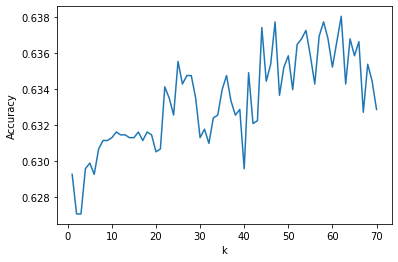

In [197]:
findK(ewma_train_bal_x, ewma_train_bal_y)

In [142]:
selector = SelectKBest(score_func=f_classif, k=62)
ewma_train_bal_x_feat = selector.fit_transform(ewma_train_bal_x, ewma_train_bal_y)
ewma_test_x_feat = selector.transform(ewma_test_x)


ewma_train_bal_x_feat_cols = []
for i in range(70):
    if selector.get_support()[i]==True:
        print(ewma_train_bal_x.columns[i])
        ewma_train_bal_x_feat_cols.append(ewma_train_bal_x.columns[i])
        
print("")
print('NOT INCLUDED:')

for i in range(70):
    if selector.get_support()[i]==False:
        print(ewma_train_bal_x.columns[i])

BACK_BACK_y
NET_MIN
NET_PTS
NET_FGM
NET_FGA
NET_FG_PCT
NET_FG3M
NET_FG3A
NET_FG3_PCT
NET_FTM
NET_FTA
NET_FT_PCT
NET_OREB
NET_DREB
NET_REB
NET_AST
NET_STL
NET_BLK
NET_TOV
NET_PLUS_MINUS
NET_OFF_RATING
NET_DEF_RATING
NET_NET_RATING
NET_AST_PCT
NET_AST_TOV
NET_AST_RATIO
NET_DREB_PCT
NET_REB_PCT
NET_TM_TOV_PCT
NET_EFG_PCT
NET_TS_PCT
NET_PACE
NET_PACE_PER40
NET_POSS
NET_PIE
NET_KEY_DNP
NET_GAME_NUMBER
NET_PTS_opp
NET_FG_PCT_opp
NET_FG3M_opp
NET_FG3A_opp
NET_FG3_PCT_opp
NET_OREB_opp
NET_DREB_opp
NET_REB_opp
NET_STL_opp
NET_BLK_opp
NET_PF_opp
NET_OFF_RATING_opp
NET_DEF_RATING_opp
NET_NET_RATING_opp
NET_OREB_PCT_opp
NET_REB_PCT_opp
NET_TM_TOV_PCT_opp
NET_EFG_PCT_opp
NET_TS_PCT_opp
NET_PIE_opp
NET_WIN_PERC
NET_FTA_opp
NET_KEY_DNP_opp
NET_GAMES_PLAYED_7
NET_ELO

NOT INCLUDED:
PLAYOFF_IND_x
BACK_BACK_x
REST_x
REST_y
NET_PF
NET_OREB_PCT
NET_TOV_opp
NET_DREB_PCT_opp


/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

k = 1: Accuracy = 0.6293
k = 2: Accuracy = 0.6271
k = 3: Accuracy = 0.6271
k = 4: Accuracy = 0.6308
k = 5: Accuracy = 0.6300
k = 6: Accuracy = 0.6299
k = 7: Accuracy = 0.6313
k = 8: Accuracy = 0.6318
k = 9: Accuracy = 0.6318
k = 10: Accuracy = 0.6308
k = 11: Accuracy = 0.6305
k = 12: Accuracy = 0.6277
k = 13: Accuracy = 0.6288
k = 14: Accuracy = 0.6288
k = 15: Accuracy = 0.6286
k = 16: Accuracy = 0.6288
k = 17: Accuracy = 0.6290
k = 18: Accuracy = 0.6299
k = 19: Accuracy = 0.6299
k = 20: Accuracy = 0.6299
k = 21: Accuracy = 0.6285
k = 22: Accuracy = 0.6335
k = 23: Accuracy = 0.6338
k = 24: Accuracy = 0.6354
k = 25: Accuracy = 0.6347
k = 26: Accuracy = 0.6340
k = 27: Accuracy = 0.6330
k = 28: Accuracy = 0.6340
k = 29: Accuracy = 0.6327
k = 30: Accuracy = 0.6329
k = 31: Accuracy = 0.6338
k = 32: Accuracy = 0.6346
k = 33: Accuracy = 0.6347
k = 34: Accuracy = 0.6346
k = 35: Accuracy = 0.6346
k = 36: Accuracy = 0.6344
k = 37: Accuracy = 0.6354
k = 38: Accuracy = 0.6351
k = 39: Accuracy = 0.

/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

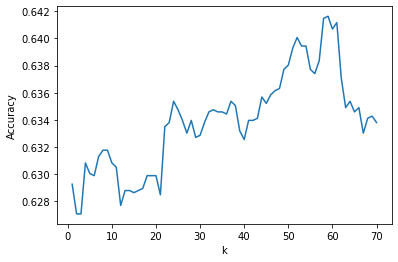

In [200]:
findK(ewma_train_bal_x_scale, ewma_train_bal_y)

In [144]:
selector = SelectKBest(score_func=f_classif, k=59)
ewma_train_bal_x_scale_feat = selector.fit_transform(ewma_train_bal_x_scale, ewma_train_bal_y)
ewma_test_x_scale_feat = selector.transform(ewma_test_x_scale)


ewma_train_bal_x_scale_feat_cols = []
for i in range(70):
    if selector.get_support()[i]==True:
        print(ewma_train_bal_x.columns[i])
        ewma_train_bal_x_scale_feat_cols.append(ewma_train_bal_x.columns[i])
        
print("")
print('NOT INCLUDED:')

for i in range(70):
    if selector.get_support()[i]==False:
        print(ewma_train_bal_x.columns[i])

BACK_BACK_y
NET_MIN
NET_PTS
NET_FGM
NET_FGA
NET_FG_PCT
NET_FG3M
NET_FG3A
NET_FG3_PCT
NET_FTM
NET_FTA
NET_FT_PCT
NET_DREB
NET_REB
NET_AST
NET_STL
NET_BLK
NET_TOV
NET_PLUS_MINUS
NET_OFF_RATING
NET_DEF_RATING
NET_NET_RATING
NET_AST_PCT
NET_AST_TOV
NET_AST_RATIO
NET_DREB_PCT
NET_REB_PCT
NET_TM_TOV_PCT
NET_EFG_PCT
NET_TS_PCT
NET_PACE
NET_PACE_PER40
NET_POSS
NET_PIE
NET_KEY_DNP
NET_GAME_NUMBER
NET_PTS_opp
NET_FG_PCT_opp
NET_FG3M_opp
NET_FG3_PCT_opp
NET_OREB_opp
NET_DREB_opp
NET_REB_opp
NET_STL_opp
NET_BLK_opp
NET_PF_opp
NET_OFF_RATING_opp
NET_DEF_RATING_opp
NET_NET_RATING_opp
NET_OREB_PCT_opp
NET_REB_PCT_opp
NET_EFG_PCT_opp
NET_TS_PCT_opp
NET_PIE_opp
NET_WIN_PERC
NET_FTA_opp
NET_KEY_DNP_opp
NET_GAMES_PLAYED_7
NET_ELO

NOT INCLUDED:
PLAYOFF_IND_x
BACK_BACK_x
REST_x
REST_y
NET_OREB
NET_PF
NET_OREB_PCT
NET_FG3A_opp
NET_TOV_opp
NET_DREB_PCT_opp
NET_TM_TOV_PCT_opp


# Logistic Regression

### Sliding all features

In [177]:
param_grid = {
    'penalty': ['none', 'l1', 'l2', 'elasticnet'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'saga'],
    'max_iter': [500,1000]
}

grid_search = GridSearchCV(logisticRegr, param_grid, cv=5)

grid_search.fit(sliding_train_bal_x, sliding_train_bal_y)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn

Best Hyperparameters: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'}
Best Accuracy: 0.6431924882629108


/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [30]:
logisticRegr = LogisticRegression(C=0.1, max_iter=1000, penalty='l1', solver='saga')
logisticRegr.fit(sliding_train_bal_x, sliding_train_bal_y)

score = logisticRegr.score(sliding_train_bal_x, sliding_train_bal_y)
print("Train acc:", score)

score = logisticRegr.score(sliding_test_x, sliding_test_y)
print("Test acc:", score)

Train acc: 0.6488262910798122
Test acc: 0.6420605416887945


/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [308]:
y_pred = logisticRegr.predict(sliding_test_x)

f1 = f1_score(sliding_test_y, y_pred)
recall = recall_score(sliding_test_y, y_pred)
precision = precision_score(sliding_test_y, y_pred)

y_pred_probs = logisticRegr.predict_proba(sliding_test_x)[:, 1]
auc = roc_auc_score(sliding_test_y, y_pred_probs)

print("F1 score:", f1)
print("Recall:", recall)
print("Precision:", precision)
print("AUC-ROC score:", auc)

F1 score: 0.6799620132953466
Recall: 0.6648096564531105
Precision: 0.6958211856171039
AUC-ROC score: 0.6818902336469055


### Sliding all features (scaled)

In [180]:
param_grid = {
    'penalty': ['none', 'l1', 'l2', 'elasticnet'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'saga'],
    'max_iter': [500,1000]
}

grid_search = GridSearchCV(logisticRegr, param_grid, cv=5)

grid_search.fit(sliding_train_bal_x_scale, sliding_train_bal_y)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn

Best Hyperparameters: {'C': 0.01, 'max_iter': 500, 'penalty': 'l1', 'solver': 'saga'}
Best Accuracy: 0.6411580594679187


/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
120 fits failed out of a total of 320.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", lin

In [31]:
logisticRegr = LogisticRegression(C=0.1, max_iter=500, penalty='l1', solver='saga')
logisticRegr.fit(sliding_train_bal_x_scale, sliding_train_bal_y)

score = logisticRegr.score(sliding_train_bal_x_scale, sliding_train_bal_y)
print("Train acc:", score)

score = logisticRegr.score(sliding_test_x_scale, sliding_test_y)
print("Test acc:", score)

Train acc: 0.6492957746478873
Test acc: 0.6431226765799256


In [310]:
y_pred = logisticRegr.predict(sliding_test_x_scale)

f1 = f1_score(sliding_test_y, y_pred)
recall = recall_score(sliding_test_y, y_pred)
precision = precision_score(sliding_test_y, y_pred)

y_pred_probs = logisticRegr.predict_proba(sliding_test_x_scale)[:, 1]
auc = roc_auc_score(sliding_test_y, y_pred_probs)

print("F1 score:", f1)
print("Recall:", recall)
print("Precision:", precision)
print("AUC-ROC score:", auc)

F1 score: 0.6772334293948127
Recall: 0.6545961002785515
Precision: 0.7014925373134329
AUC-ROC score: 0.6813983332987736


### Sliding feature selection

In [190]:
param_grid = {
    'penalty': ['none', 'l1', 'l2', 'elasticnet'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'saga'],
    'max_iter': [500,1000]
}

grid_search = GridSearchCV(logisticRegr, param_grid, cv=5)

grid_search.fit(sliding_train_bal_x_feat, sliding_train_bal_y)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn

Best Hyperparameters: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
Best Accuracy: 0.6463223787167449


/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
120 fits failed out of a total of 320.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", lin

In [32]:
logisticRegr = LogisticRegression(C=0.001, max_iter=1000, penalty='l1', solver='liblinear')
logisticRegr.fit(sliding_train_bal_x_feat, sliding_train_bal_y)

score = logisticRegr.score(sliding_train_bal_x_feat, sliding_train_bal_y)
print("Train acc:", score)

score = logisticRegr.score(sliding_test_x_feat, sliding_test_y)
print("Test acc:", score)


Train acc: 0.6251956181533647
Test acc: 0.6611789697291556


In [312]:
y_pred = logisticRegr.predict(sliding_test_x_feat)

f1 = f1_score(sliding_test_y, y_pred)
recall = recall_score(sliding_test_y, y_pred)
precision = precision_score(sliding_test_y, y_pred)

y_pred_probs = logisticRegr.predict_proba(sliding_test_x_feat)[:, 1]
auc = roc_auc_score(sliding_test_y, y_pred_probs)

print("F1 score:", f1)
print("Recall:", recall)
print("Precision:", precision)
print("AUC-ROC score:", auc)

F1 score: 0.7251612903225806
Recall: 0.7827298050139275
Precision: 0.6754807692307693
AUC-ROC score: 0.6798765525964734


### Sliding feature selection (Scaled)

In [165]:
param_grid = {
    'penalty': ['none', 'l1', 'l2', 'elasticnet'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'saga'],
    'max_iter': [500,1000]
}

grid_search = GridSearchCV(logisticRegr, param_grid, cv=5)

grid_search.fit(sliding_train_bal_x_scale_feat, sliding_train_bal_y)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn

Best Hyperparameters: {'C': 0.1, 'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear'}
Best Accuracy: 0.6430359937402191


/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
120 fits failed out of a total of 320.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", lin

In [33]:
logisticRegr = LogisticRegression(C=1, max_iter=500, penalty='l1', solver='liblinear')
logisticRegr.fit(sliding_train_bal_x_scale_feat, sliding_train_bal_y)

score = logisticRegr.score(sliding_train_bal_x_scale_feat, sliding_train_bal_y)
print("Train acc:", score)

score = logisticRegr.score(sliding_test_x_scale_feat, sliding_test_y)
print("Test acc:", score)


Train acc: 0.6489827856025039
Test acc: 0.6436537440254912


In [314]:
y_pred = logisticRegr.predict(sliding_test_x_scale_feat)

f1 = f1_score(sliding_test_y, y_pred)
recall = recall_score(sliding_test_y, y_pred)
precision = precision_score(sliding_test_y, y_pred)

y_pred_probs = logisticRegr.predict_proba(sliding_test_x_scale_feat)[:, 1]
auc = roc_auc_score(sliding_test_y, y_pred_probs)

print("F1 score:", f1)
print("Recall:", recall)
print("Precision:", precision)
print("AUC-ROC score:", auc)

F1 score: 0.6772334293948127
Recall: 0.6545961002785515
Precision: 0.7014925373134329
AUC-ROC score: 0.6821356078252474


### EWMA all features

In [210]:
param_grid = {
    'penalty': ['none', 'l1', 'l2', 'elasticnet'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'saga'],
    'max_iter': [500,1000]
}

grid_search = GridSearchCV(logisticRegr, param_grid, cv=5)

grid_search.fit(ewma_train_bal_x, ewma_train_bal_y)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn

Best Hyperparameters: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
Best Accuracy: 0.6389671361502347


/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
120 fits failed out of a total of 320.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", lin

In [35]:
logisticRegr = LogisticRegression(C=0.1, max_iter=1000, penalty='l1', solver='liblinear')
logisticRegr.fit(ewma_train_bal_x, ewma_train_bal_y)

score = logisticRegr.score(ewma_train_bal_x, ewma_train_bal_y)
print("Train acc:", score)

score = logisticRegr.score(ewma_test_x, ewma_test_y)
print("Test acc:", score)

Train acc: 0.6406885758998435
Test acc: 0.6425916091343601


In [316]:
y_pred = logisticRegr.predict(ewma_test_x)

f1 = f1_score(ewma_test_y, y_pred)
recall = recall_score(ewma_test_y, y_pred)
precision = precision_score(ewma_test_y, y_pred)

y_pred_probs = logisticRegr.predict_proba(ewma_test_x)[:, 1]
auc = roc_auc_score(ewma_test_y, y_pred_probs)

print("F1 score:", f1)
print("Recall:", recall)
print("Precision:", precision)
print("AUC-ROC score:", auc)

F1 score: 0.6743961352657005
Recall: 0.6480965645311049
Precision: 0.702920443101712
AUC-ROC score: 0.6804030126880338


### EWMA All features scaled

In [212]:
param_grid = {
    'penalty': ['none', 'l1', 'l2', 'elasticnet'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'saga'],
    'max_iter': [500,1000]
}

grid_search = GridSearchCV(logisticRegr, param_grid, cv=5)

grid_search.fit(ewma_train_bal_x_scale, ewma_train_bal_y)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn

Best Hyperparameters: {'C': 0.1, 'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear'}
Best Accuracy: 0.6402190923317684


/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
120 fits failed out of a total of 320.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", lin

In [36]:
logisticRegr = LogisticRegression(C=0.01, max_iter=500, penalty='l1', solver='liblinear')
logisticRegr.fit(ewma_train_bal_x_scale, ewma_train_bal_y)

score = logisticRegr.score(ewma_train_bal_x_scale, ewma_train_bal_y)
print("Train acc:", score)

score = logisticRegr.score(ewma_test_x_scale, ewma_test_y)
print("Test acc:", score)

Train acc: 0.6377151799687011
Test acc: 0.6447158789166224


In [318]:
y_pred = logisticRegr.predict(ewma_test_x_scale)

f1 = f1_score(ewma_test_y, y_pred)
recall = recall_score(ewma_test_y, y_pred)
precision = precision_score(ewma_test_y, y_pred)

y_pred_probs = logisticRegr.predict_proba(ewma_test_x_scale)[:, 1]
auc = roc_auc_score(ewma_test_y, y_pred_probs)

print("F1 score:", f1)
print("Recall:", recall)
print("Precision:", precision)
print("AUC-ROC score:", auc)

F1 score: 0.677590361445783
Recall: 0.6527390900649953
Precision: 0.7044088176352705
AUC-ROC score: 0.6800597192366444


### EWMA Feature Selection

In [214]:
param_grid = {
    'penalty': ['none', 'l1', 'l2', 'elasticnet'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'saga'],
    'max_iter': [500,1000]
}

grid_search = GridSearchCV(logisticRegr, param_grid, cv=5)

grid_search.fit(ewma_train_bal_x_feat, ewma_train_bal_y)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn

Best Hyperparameters: {'C': 10, 'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear'}
Best Accuracy: 0.6416275430359937


In [38]:
logisticRegr = LogisticRegression(C=0.001, max_iter=500, penalty='l1', solver='liblinear')
logisticRegr.fit(ewma_train_bal_x_feat, ewma_train_bal_y)

score = logisticRegr.score(ewma_test_x_feat, ewma_test_y)
print("Train acc:", score)

score = logisticRegr.score(ewma_test_x_feat, ewma_test_y)
print("Test acc:", score)

Train acc: 0.6537440254912373
Test acc: 0.6537440254912373


In [320]:
y_pred = logisticRegr.predict(ewma_test_x_feat)

f1 = f1_score(ewma_test_y, y_pred)
recall = recall_score(ewma_test_y, y_pred)
precision = precision_score(ewma_test_y, y_pred)

y_pred_probs = logisticRegr.predict_proba(ewma_test_x_feat)[:, 1]
auc = roc_auc_score(ewma_test_y, y_pred_probs)

print("F1 score:", f1)
print("Recall:", recall)
print("Precision:", precision)
print("AUC-ROC score:", auc)

F1 score: 0.7290108063175395
Recall: 0.8142989786443825
Precision: 0.6598946576373212
AUC-ROC score: 0.6813856613928498


### EWMA Feature selection scaled

In [216]:
param_grid = {
    'penalty': ['none', 'l1', 'l2', 'elasticnet'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'saga'],
    'max_iter': [500,1000]
}

grid_search = GridSearchCV(logisticRegr, param_grid, cv=5)

grid_search.fit(ewma_train_bal_x_scale_feat, ewma_train_bal_y)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn

Best Hyperparameters: {'C': 10, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'}
Best Accuracy: 0.6400625978090767


/Users/Tim/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [39]:
logisticRegr = LogisticRegression(C=0.01, max_iter=1000, penalty='l1', solver='saga')
logisticRegr.fit(ewma_train_bal_x_scale_feat, ewma_train_bal_y)

score = logisticRegr.score(ewma_train_bal_x_scale_feat, ewma_train_bal_y)
print("Train acc:", score)

score = logisticRegr.score(ewma_test_x_scale_feat, ewma_test_y)
print("Test acc:", score)

Train acc: 0.6377151799687011
Test acc: 0.6447158789166224


In [323]:
y_pred = logisticRegr.predict(ewma_test_x_scale_feat)

f1 = f1_score(ewma_test_y, y_pred)
recall = recall_score(ewma_test_y, y_pred)
precision = precision_score(ewma_test_y, y_pred)

y_pred_probs = logisticRegr.predict_proba(ewma_test_x_scale_feat)[:, 1]
auc = roc_auc_score(ewma_test_y, y_pred_probs)

print("F1 score:", f1)
print("Recall:", recall)
print("Precision:", precision)
print("AUC-ROC score:", auc)

F1 score: 0.677590361445783
Recall: 0.6527390900649953
Precision: 0.7044088176352705
AUC-ROC score: 0.6800723911425681


# Random Forest Model

### Sliding all features

In [385]:
rf = RandomForestClassifier()

param_grid = {'max_depth': [5, 10, 15, 20],
                 'max_features': ['auto', 'log2'],
                 'n_estimators': [50, 100],
                'min_samples_leaf': [15, 20]}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)

grid_search.fit(sliding_train_bal_x, sliding_train_bal_y)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Best Hyperparameters: {'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 15, 'n_estimators': 50}
Best Accuracy: 0.6455399061032864


In [386]:
rf = RandomForestClassifier(bootstrap = True, max_depth=20, max_features='log2', n_estimators=50,min_samples_leaf=15, random_state = 7)
rf.fit(sliding_train_bal_x, sliding_train_bal_y)

train_predictions = rf.predict(sliding_train_bal_x)
score = accuracy_score(sliding_train_bal_y, train_predictions)
print("Train acc:", score)

score = rf.score(sliding_test_x, sliding_test_y)
print("Test acc:", score)

Train acc: 0.8420970266040688
Test acc: 0.6261285183218269


In [387]:
y_pred = rf.predict(sliding_test_x)

f1 = f1_score(sliding_test_y, y_pred)
recall = recall_score(sliding_test_y, y_pred)
precision = precision_score(sliding_test_y, y_pred)

y_pred_probs = rf.predict_proba(sliding_test_x)[:, 1]
auc = roc_auc_score(sliding_test_y, y_pred_probs)

print("F1 score:", f1)
print("Recall:", recall)
print("Precision:", precision)
print("AUC-ROC score:", auc)

F1 score: 0.6688617121354657
Recall: 0.6601671309192201
Precision: 0.6777883698760725
AUC-ROC score: 0.657153521292258


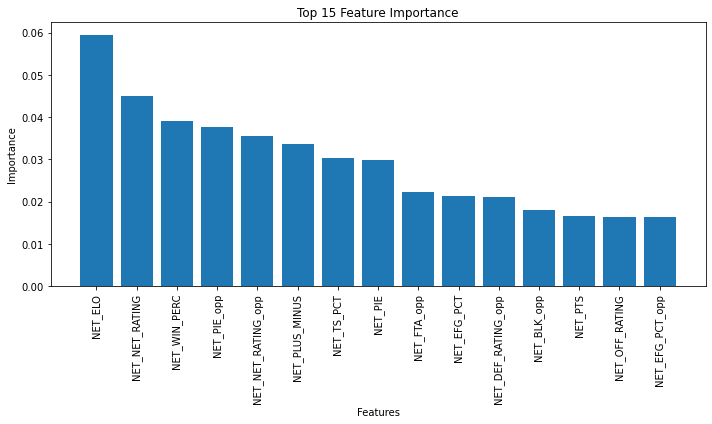

In [388]:
import matplotlib.pyplot as plt

importances = rf.feature_importances_

indices = np.argsort(importances)[::-1]

top_15_indices = indices[:15]

top_15_features = sliding_train_bal_x.columns[top_15_indices]
top_15_importances = importances[top_15_indices]

plt.figure(figsize=(10, 6))
plt.title("Top 15 Feature Importance")
plt.bar(range(len(top_15_features)), top_15_importances, align="center")
plt.xticks(range(len(top_15_features)), top_15_features, rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

### Sliding all features scale

In [389]:
rf = RandomForestClassifier()

param_grid = {'max_depth': [5, 10, 15, 20],
                 'max_features': ['auto', 'log2'],
                 'n_estimators': [50, 100],
                'min_samples_leaf': [15, 20]}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)

grid_search.fit(sliding_train_bal_x_scale, sliding_train_bal_y)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Best Hyperparameters: {'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 15, 'n_estimators': 100}
Best Accuracy: 0.6449139280125195


In [390]:
rf = RandomForestClassifier(bootstrap = True, max_depth=20, max_features='auto', n_estimators=100, min_samples_leaf = 15,random_state = 7)
rf.fit(sliding_train_bal_x_scale, sliding_train_bal_y)

score = rf.score(sliding_train_bal_x_scale, sliding_train_bal_y)
print("Train acc:", score)

score = rf.score(sliding_test_x_scale, sliding_test_y)
print("Test acc:", score)

Train acc: 0.8577464788732394
Test acc: 0.6309081253319172


In [391]:
y_pred = rf.predict(sliding_test_x_scale)

f1 = f1_score(sliding_test_y, y_pred)
recall = recall_score(sliding_test_y, y_pred)
precision = precision_score(sliding_test_y, y_pred)

y_pred_probs = rf.predict_proba(sliding_test_x_scale)[:, 1]
auc = roc_auc_score(sliding_test_y, y_pred_probs)

print("F1 score:", f1)
print("Recall:", recall)
print("Precision:", precision)
print("AUC-ROC score:", auc)

F1 score: 0.6741678387248008
Recall: 0.6675951717734447
Precision: 0.6808712121212122
AUC-ROC score: 0.6644847948648829


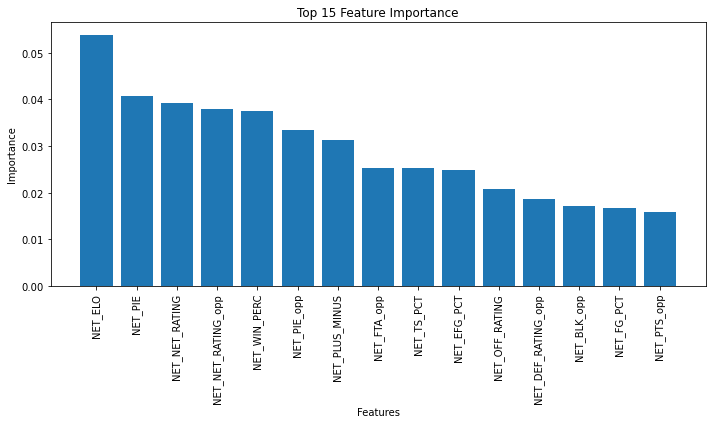

In [392]:
importances = rf.feature_importances_

indices = np.argsort(importances)[::-1]

top_15_indices = indices[:15]

top_15_features = sliding_train_bal_x.columns[top_15_indices]
top_15_importances = importances[top_15_indices]

plt.figure(figsize=(10, 6))
plt.title("Top 15 Feature Importance")
plt.bar(range(len(top_15_features)), top_15_importances, align="center")
plt.xticks(range(len(top_15_features)), top_15_features, rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

### Sliding feature selection 

In [393]:
rf = RandomForestClassifier()

param_grid = {'max_depth': [5, 10, 15, 20],
                 'max_features': ['auto', 'log2'],
                 'n_estimators': [50, 100],
                'min_samples_leaf': [15, 20]}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)

grid_search.fit(sliding_train_bal_x_feat, sliding_train_bal_y)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Best Hyperparameters: {'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 15, 'n_estimators': 50}
Best Accuracy: 0.6486697965571205


In [394]:
rf = RandomForestClassifier(bootstrap = True, max_depth=20, max_features='auto', n_estimators=50, min_samples_leaf = 15,random_state=7)
rf.fit(sliding_train_bal_x_feat, sliding_train_bal_y)

score = rf.score(sliding_train_bal_x_feat, sliding_train_bal_y)
print("Train acc:", score)

score = rf.score(sliding_test_x_feat, sliding_test_y)
print("Test acc:", score)

Train acc: 0.8410015649452269
Test acc: 0.6245353159851301


In [395]:
y_pred = rf.predict(sliding_test_x_feat)

f1 = f1_score(sliding_test_y, y_pred)
recall = recall_score(sliding_test_y, y_pred)
precision = precision_score(sliding_test_y, y_pred)

y_pred_probs = rf.predict_proba(sliding_test_x_feat)[:, 1]
auc = roc_auc_score(sliding_test_y, y_pred_probs)

print("F1 score:", f1)
print("Recall:", recall)
print("Precision:", precision)
print("AUC-ROC score:", auc)

F1 score: 0.6672941176470589
Recall: 0.6583101207056639
Precision: 0.6765267175572519
AUC-ROC score: 0.6678716497208723


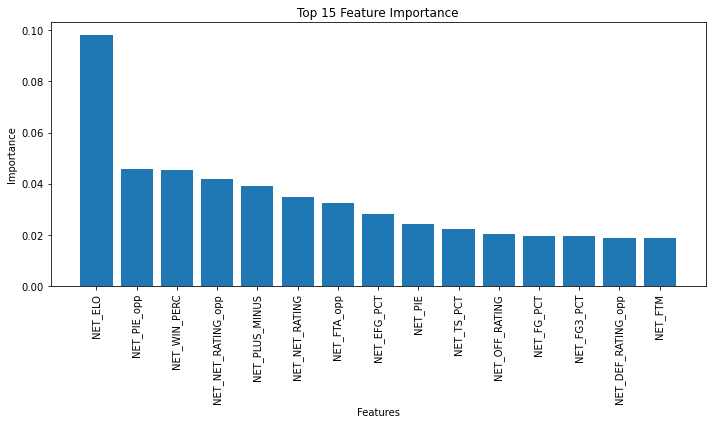

In [396]:
importances = rf.feature_importances_

indices = np.argsort(importances)[::-1]

top_15_indices = indices[:15]

top_15_features = []

for i in top_15_indices:
    top_15_features.append(sliding_train_bal_x_feat_cols[i])

top_15_importances = importances[top_15_indices]

plt.figure(figsize=(10, 6))
plt.title("Top 15 Feature Importance")
plt.bar(range(len(top_15_features)), top_15_importances, align="center")
plt.xticks(range(len(top_15_features)), top_15_features, rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

### Sliding features scale

In [397]:
rf = RandomForestClassifier()

param_grid = {'max_depth': [5, 10, 15, 20],
                 'max_features': ['auto', 'log2'],
                 'n_estimators': [50, 100],
                'min_samples_leaf': [15, 20]}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)

grid_search.fit(sliding_train_bal_x_scale_feat, sliding_train_bal_y)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Best Hyperparameters: {'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 15, 'n_estimators': 100}
Best Accuracy: 0.6507042253521126


In [401]:
rf = RandomForestClassifier(bootstrap = True, max_depth=20, max_features='auto', n_estimators=100, min_samples_leaf=15, random_state=7)
rf.fit(sliding_train_bal_x_scale_feat, sliding_train_bal_y)

score = rf.score(sliding_train_bal_x_scale_feat, sliding_train_bal_y)
print("Train acc:", score)

score = rf.score(sliding_test_x_scale_feat, sliding_test_y)
print("Test acc:", score)

Train acc: 0.8513302034428795
Test acc: 0.6325013276686139


In [402]:
y_pred = rf.predict(sliding_test_x_scale_feat)

f1 = f1_score(sliding_test_y, y_pred)
recall = recall_score(sliding_test_y, y_pred)
precision = precision_score(sliding_test_y, y_pred)

y_pred_probs = rf.predict_proba(sliding_test_x_scale_feat)[:, 1]
auc = roc_auc_score(sliding_test_y, y_pred_probs)

print("F1 score:", f1)
print("Recall:", recall)
print("Precision:", precision)
print("AUC-ROC score:", auc)

F1 score: 0.6751173708920187
Recall: 0.6675951717734447
Precision: 0.6828110161443495
AUC-ROC score: 0.6650296868196051


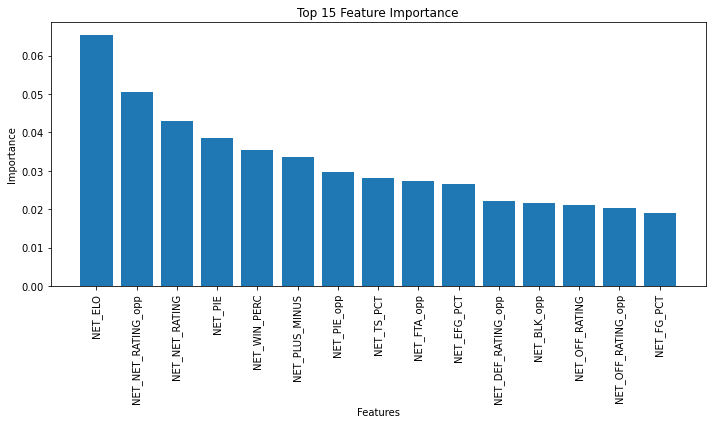

In [403]:
importances = rf.feature_importances_

indices = np.argsort(importances)[::-1]

top_15_indices = indices[:15]

top_15_features = []

for i in top_15_indices:
    top_15_features.append(sliding_train_bal_x_scale_feat_cols[i])

top_15_importances = importances[top_15_indices]

plt.figure(figsize=(10, 6))
plt.title("Top 15 Feature Importance")
plt.bar(range(len(top_15_features)), top_15_importances, align="center")
plt.xticks(range(len(top_15_features)), top_15_features, rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

### EWMA All features

In [404]:
rf = RandomForestClassifier()

param_grid = {'max_depth': [5, 10, 15, 20],
                 'max_features': ['auto', 'log2'],
                 'n_estimators': [50, 100],
                'min_samples_leaf': [15, 20]}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)

grid_search.fit(ewma_train_bal_x, ewma_train_bal_y)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Best Hyperparameters: {'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 15, 'n_estimators': 100}
Best Accuracy: 0.6513302034428795


In [405]:
rf = RandomForestClassifier(bootstrap = True, max_depth=20, max_features='auto', n_estimators=100,min_samples_leaf=15, random_state=7)
rf.fit(ewma_train_bal_x, ewma_train_bal_y)

score = rf.score(ewma_train_bal_x, ewma_train_bal_y)
print("Train acc:", score)

score = rf.score(ewma_test_x, ewma_test_y)
print("Test acc:", score)

Train acc: 0.85962441314554
Test acc: 0.6325013276686139


In [406]:
y_pred = rf.predict(ewma_test_x)

f1 = f1_score(ewma_test_y, y_pred)
recall = recall_score(ewma_test_y, y_pred)
precision = precision_score(ewma_test_y, y_pred)

y_pred_probs = rf.predict_proba(ewma_test_x)[:, 1]
auc = roc_auc_score(ewma_test_y, y_pred_probs)

print("F1 score:", f1)
print("Recall:", recall)
print("Precision:", precision)
print("AUC-ROC score:", auc)

F1 score: 0.6723484848484849
Recall: 0.659238625812442
Precision: 0.6859903381642513
AUC-ROC score: 0.6674696047056548


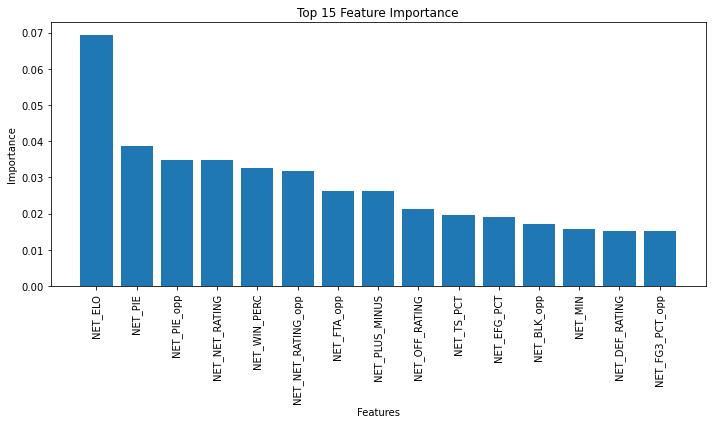

In [407]:
importances = rf.feature_importances_

indices = np.argsort(importances)[::-1]

top_15_indices = indices[:15]

top_15_features = ewma_train_bal_x.columns[top_15_indices]
top_15_importances = importances[top_15_indices]

plt.figure(figsize=(10, 6))
plt.title("Top 15 Feature Importance")
plt.bar(range(len(top_15_features)), top_15_importances, align="center")
plt.xticks(range(len(top_15_features)), top_15_features, rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

### EWMA All features scale

In [408]:
rf = RandomForestClassifier()

param_grid = {'max_depth': [5, 10, 15, 20],
                 'max_features': ['auto', 'log2'],
                 'n_estimators': [50, 100],
                'min_samples_leaf': [15, 20]}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)

grid_search.fit(ewma_train_bal_x_scale, ewma_train_bal_y)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Best Hyperparameters: {'max_depth': 15, 'max_features': 'auto', 'min_samples_leaf': 15, 'n_estimators': 50}
Best Accuracy: 0.6525821596244132


In [409]:
rf = RandomForestClassifier(bootstrap = True, max_depth=15, max_features='auto', n_estimators=50, min_samples_leaf=15, random_state=7)
rf.fit(ewma_train_bal_x_scale, ewma_train_bal_y)

score = rf.score(ewma_train_bal_x_scale, ewma_train_bal_y)
print("Test acc:", score)

score = rf.score(ewma_test_x_scale, ewma_test_y)
print("Test acc:", score)

Test acc: 0.8530516431924883
Test acc: 0.6351566648964418


In [410]:
y_pred = rf.predict(ewma_test_x_scale)

f1 = f1_score(ewma_test_y, y_pred)
recall = recall_score(ewma_test_y, y_pred)
precision = precision_score(ewma_test_y, y_pred)

y_pred_probs = rf.predict_proba(ewma_test_x_scale)[:, 1]
auc = roc_auc_score(ewma_test_y, y_pred_probs)

print("F1 score:", f1)
print("Recall:", recall)
print("Precision:", precision)
print("AUC-ROC score:", auc)

F1 score: 0.675177304964539
Recall: 0.6629526462395543
Precision: 0.6878612716763006
AUC-ROC score: 0.6693577186882964


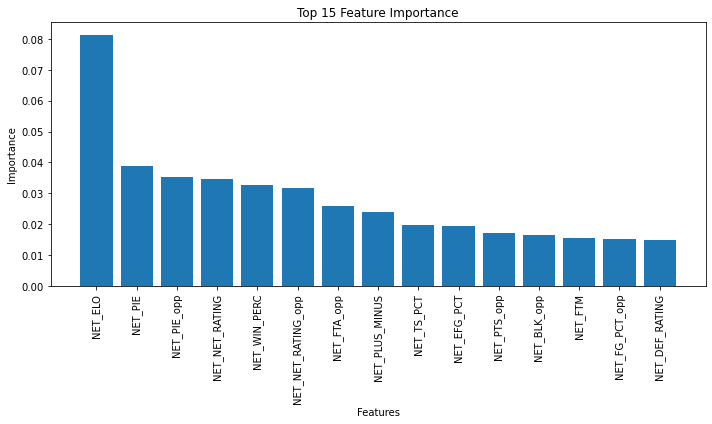

In [411]:
importances = rf.feature_importances_

indices = np.argsort(importances)[::-1]

top_15_indices = indices[:15]

top_15_features = ewma_train_bal_x.columns[top_15_indices]
top_15_importances = importances[top_15_indices]

plt.figure(figsize=(10, 6))
plt.title("Top 15 Feature Importance")
plt.bar(range(len(top_15_features)), top_15_importances, align="center")
plt.xticks(range(len(top_15_features)), top_15_features, rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

### EWMA feature selection

In [418]:
rf = RandomForestClassifier()

param_grid = {'max_depth': [5, 10, 15, 20],
                 'max_features': ['auto', 'log2'],
                 'n_estimators': [50, 100],
                'min_samples_leaf': [15, 20]}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)

grid_search.fit(ewma_train_bal_x_feat, ewma_train_bal_y)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Best Hyperparameters: {'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 15, 'n_estimators': 100}
Best Accuracy: 0.6489827856025039


In [422]:
rf = RandomForestClassifier(bootstrap = True, max_depth=15, max_features='log2', n_estimators=100, min_samples_leaf=15, random_state=7)
rf.fit(ewma_train_bal_x_feat, ewma_train_bal_y)

score = rf.score(ewma_train_bal_x_feat, ewma_train_bal_y)
print("Train acc:", score)

score = rf.score(ewma_test_x_feat, ewma_test_y)
print("Test acc:", score)

Train acc: 0.8399061032863849
Test acc: 0.6282527881040892


In [423]:
y_pred = rf.predict(ewma_test_x_feat)

f1 = f1_score(ewma_test_y, y_pred)
recall = recall_score(ewma_test_y, y_pred)
precision = precision_score(ewma_test_y, y_pred)

y_pred_probs = rf.predict_proba(ewma_test_x_feat)[:, 1]
auc = roc_auc_score(ewma_test_y, y_pred_probs)

print("F1 score:", f1)
print("Recall:", recall)
print("Precision:", precision)
print("AUC-ROC score:", auc)

F1 score: 0.6694995278564684
Recall: 0.6583101207056639
Precision: 0.681075888568684
AUC-ROC score: 0.66959272494361


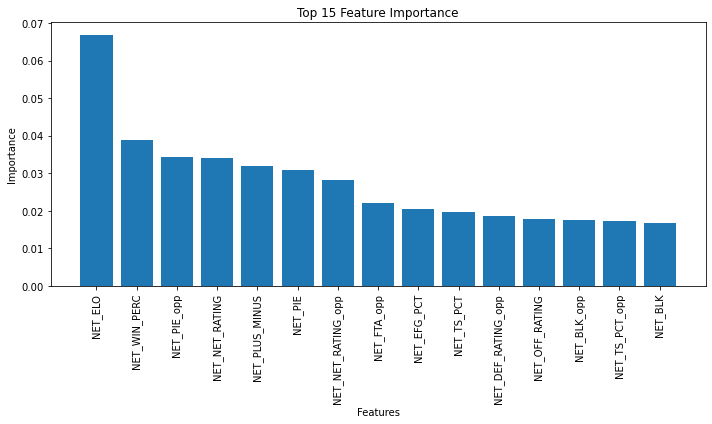

In [424]:
importances = rf.feature_importances_

indices = np.argsort(importances)[::-1]

top_15_indices = indices[:15]

top_15_features = []

for i in top_15_indices:
    top_15_features.append(ewma_train_bal_x_feat_cols[i])

top_15_importances = importances[top_15_indices]

plt.figure(figsize=(10, 6))
plt.title("Top 15 Feature Importance")
plt.bar(range(len(top_15_features)), top_15_importances, align="center")
plt.xticks(range(len(top_15_features)), top_15_features, rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

### EWMA feature selection scale

In [425]:
rf = RandomForestClassifier()

param_grid = {'max_depth': [5, 10, 15, 20],
                 'max_features': ['auto', 'log2'],
                 'n_estimators': [50, 100],
                'min_samples_leaf': [15, 20]}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)

grid_search.fit(ewma_train_bal_x_scale_feat, ewma_train_bal_y)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Best Hyperparameters: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 15, 'n_estimators': 50}
Best Accuracy: 0.6508607198748043


In [426]:
rf = RandomForestClassifier(bootstrap = True, max_depth=20, max_features='log2', n_estimators=50, min_samples_leaf = 15, random_state=7)
rf.fit(ewma_train_bal_x_scale_feat, ewma_train_bal_y)

score = rf.score(ewma_train_bal_x_scale_feat, ewma_train_bal_y)
print("Train acc:", score)

score = rf.score(ewma_test_x_scale_feat, ewma_test_y)
print("Test acc:", score)

Train acc: 0.8374021909233177
Test acc: 0.6303770578863516


In [427]:
y_pred = rf.predict(ewma_test_x_scale_feat)

f1 = f1_score(ewma_test_y, y_pred)
recall = recall_score(ewma_test_y, y_pred)
precision = precision_score(ewma_test_y, y_pred)

y_pred_probs = rf.predict_proba(ewma_test_x_scale_feat)[:, 1]
auc = roc_auc_score(ewma_test_y, y_pred_probs)

print("F1 score:", f1)
print("Recall:", recall)
print("Precision:", precision)
print("AUC-ROC score:", auc)

F1 score: 0.6692015209125476
Recall: 0.6536675951717734
Precision: 0.685491723466407
AUC-ROC score: 0.6648914478458913


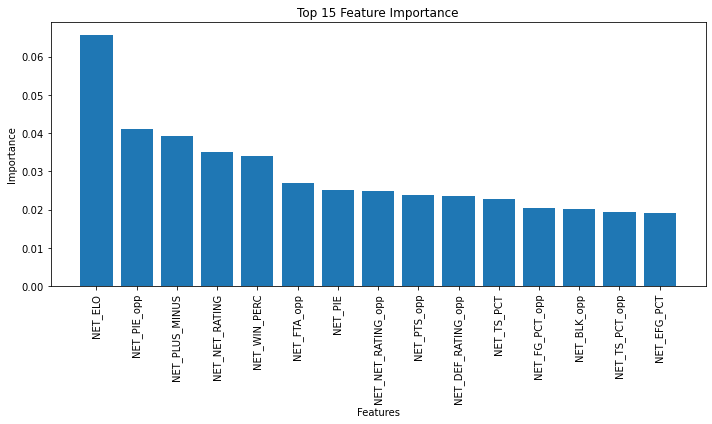

In [428]:
importances = rf.feature_importances_

indices = np.argsort(importances)[::-1]

top_15_indices = indices[:15]

top_15_features = []

for i in top_15_indices:
    top_15_features.append(ewma_train_bal_x_scale_feat_cols[i])

top_15_importances = importances[top_15_indices]

plt.figure(figsize=(10, 6))
plt.title("Top 15 Feature Importance")
plt.bar(range(len(top_15_features)), top_15_importances, align="center")
plt.xticks(range(len(top_15_features)), top_15_features, rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

# SVM

### Sliding all features

In [280]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.01, 0.1, 1, 'scale']
}

grid_search = GridSearchCV(svm, param_grid, cv=5)

grid_search.fit(sliding_train_bal_x, sliding_train_bal_y)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Best Hyperparameters: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Best Accuracy: 0.7095461658841942


In [309]:
param_grid = {
    'C': [0.01, 0.1,1],
    'kernel': ['rbf'],
    'gamma': ['scale']
}

grid_search = GridSearchCV(svm, param_grid, cv=5)

grid_search.fit(sliding_train_bal_x, sliding_train_bal_y)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Best Hyperparameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best Accuracy: 0.6361502347417841


In [310]:
## grid search 1 overfit, didnt generalize
svm = SVC(C=1, gamma = 'scale', kernel = 'rbf', probability=True)
svm.fit(sliding_train_bal_x, sliding_train_bal_y)

score = svm.score(sliding_train_bal_x, sliding_train_bal_y)
print("Train acc:",score)

score = svm.score(sliding_test_x, sliding_test_y)
print("Test acc:", score)

Train acc: 0.6366197183098592
Test acc: 0.6240042485395645


In [311]:
y_pred = svm.predict(sliding_test_x)

f1 = f1_score(sliding_test_y, y_pred)
recall = recall_score(sliding_test_y, y_pred)
precision = precision_score(sliding_test_y, y_pred)

y_pred_probs = svm.predict_proba(sliding_test_x)[:, 1]
auc = roc_auc_score(sliding_test_y, y_pred_probs)

print("F1 score:", f1)
print("Recall:", recall)
print("Precision:", precision)
print("AUC-ROC score:", auc)

F1 score: 0.6515748031496063
Recall: 0.6146703806870938
Precision: 0.6931937172774869
AUC-ROC score: 0.6694141662692296


### Sliding all features scaled

In [281]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.01, 0.1, 1, 'scale']
}

grid_search = GridSearchCV(svm, param_grid, cv=5)

grid_search.fit(sliding_train_bal_x_scale, sliding_train_bal_y)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Best Hyperparameters: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Best Accuracy: 0.7050078247261345


In [306]:
param_grid = {
    'C': [0.01, 0.1,1],
    'kernel': ['rbf'],
    'gamma': ['scale']
}

grid_search = GridSearchCV(svm, param_grid, cv=5)

grid_search.fit(sliding_train_bal_x_scale, sliding_train_bal_y)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Best Hyperparameters: {'C': 0.01, 'gamma': 'scale', 'kernel': 'rbf'}
Best Accuracy: 0.6247261345852896


In [307]:
## grid search 1 overfit, didnt generalize
svm = SVC(C=0.01, gamma = 'scale', kernel = 'rbf', probability=True)
svm.fit(sliding_train_bal_x_scale, sliding_train_bal_y)

score = svm.score(sliding_train_bal_x_scale, sliding_train_bal_y)
print("Train acc:", score)

score = svm.score(sliding_test_x_scale, sliding_test_y)
print("Test acc:", score)

Train acc: 0.6355242566510172
Test acc: 0.6340945300053107


In [308]:
y_pred = svm.predict(sliding_test_x_scale)

f1 = f1_score(sliding_test_y, y_pred)
recall = recall_score(sliding_test_y, y_pred)
precision = precision_score(sliding_test_y, y_pred)

y_pred_probs = svm.predict_proba(sliding_test_x_scale)[:, 1]
auc = roc_auc_score(sliding_test_y, y_pred_probs)

print("F1 score:", f1)
print("Recall:", recall)
print("Precision:", precision)
print("AUC-ROC score:", auc)

F1 score: 0.6682715454983148
Recall: 0.6443825441039925
Precision: 0.694
AUC-ROC score: 0.6633316514258198


### Sliding feature selection

In [282]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.01, 0.1, 1, 'scale']
}

grid_search = GridSearchCV(svm, param_grid, cv=5)

grid_search.fit(sliding_train_bal_x_feat, sliding_train_bal_y)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Best Hyperparameters: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Best Accuracy: 0.7095461658841942


In [303]:
param_grid = {
    'C': [0.01, 0.1,1],
    'kernel': ['rbf'],
    'gamma': ['scale']
}

grid_search = GridSearchCV(svm, param_grid, cv=5)

grid_search.fit(sliding_train_bal_x_feat, sliding_train_bal_y)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Best Hyperparameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best Accuracy: 0.6366197183098592


In [304]:
## grid search 1 overfit, didnt generalize
svm = SVC(C=1, gamma = 'scale', kernel = 'rbf', probability=True)
svm.fit(sliding_train_bal_x_feat, sliding_train_bal_y)

score = svm.score(sliding_train_bal_x_feat, sliding_train_bal_y)
print("Train acc:", score)

score = svm.score(sliding_test_x_feat, sliding_test_y)
print("Test acc:", score)

Train acc: 0.6359937402190924
Test acc: 0.6240042485395645


In [305]:
y_pred = svm.predict(sliding_test_x_feat)

f1 = f1_score(sliding_test_y, y_pred)
recall = recall_score(sliding_test_y, y_pred)
precision = precision_score(sliding_test_y, y_pred)

y_pred_probs = svm.predict_proba(sliding_test_x_feat)[:, 1]
auc = roc_auc_score(sliding_test_y, y_pred_probs)

print("F1 score:", f1)
print("Recall:", recall)
print("Precision:", precision)
print("AUC-ROC score:", auc)

F1 score: 0.6515748031496063
Recall: 0.6146703806870938
Precision: 0.6931937172774869
AUC-ROC score: 0.6687771149986983


### Sliding feature selection scale

In [283]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.01, 0.1, 1, 'scale']
}


grid_search = GridSearchCV(svm, param_grid, cv=5)

grid_search.fit(sliding_train_bal_x_scale_feat, sliding_train_bal_y)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Best Hyperparameters: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Best Accuracy: 0.7035993740219093


In [300]:
param_grid = {
    'C': [0.01, 0.1,1],
    'kernel': ['rbf'],
    'gamma': ['scale']
}

grid_search = GridSearchCV(svm, param_grid, cv=5)

grid_search.fit(sliding_train_bal_x_scale_feat, sliding_train_bal_y)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Best Hyperparameters: {'C': 0.01, 'gamma': 'scale', 'kernel': 'rbf'}
Best Accuracy: 0.6264475743348983


In [301]:
## grid search overfit, didnt generalize
svm = SVC(C=0.01, gamma = 'scale', kernel = 'rbf', probability=True)
svm.fit(sliding_train_bal_x_scale_feat, sliding_train_bal_y)

score = svm.score(sliding_train_bal_x_scale_feat, sliding_train_bal_y)
print("Train acc:", score)

score = svm.score(sliding_test_x_scale_feat, sliding_test_y)
print("Test acc:", score)

Train acc: 0.6347417840375587
Test acc: 0.6346255974508762


In [302]:
y_pred = svm.predict(sliding_test_x_scale_feat)

f1 = f1_score(sliding_test_y, y_pred)
recall = recall_score(sliding_test_y, y_pred)
precision = precision_score(sliding_test_y, y_pred)

y_pred_probs = svm.predict_proba(sliding_test_x_scale_feat)[:, 1]
auc = roc_auc_score(sliding_test_y, y_pred_probs)

print("F1 score:", f1)
print("Recall:", recall)
print("Precision:", precision)
print("AUC-ROC score:", auc)

F1 score: 0.6689124157844081
Recall: 0.6453110492107706
Precision: 0.6943056943056943
AUC-ROC score: 0.6629779900514019


### EWMA all features

In [284]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.01, 0.1, 1, 'scale']
}


grid_search = GridSearchCV(svm, param_grid, cv=5)

grid_search.fit(ewma_train_bal_x, ewma_train_bal_y)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Best Hyperparameters: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Best Accuracy: 0.7095461658841942


In [297]:
param_grid = {
    'C': [0.01, 0.1,1],
    'kernel': ['rbf'],
    'gamma': ['scale']
}

grid_search = GridSearchCV(svm, param_grid, cv=5)

grid_search.fit(ewma_train_bal_x, ewma_train_bal_y)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Best Hyperparameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best Accuracy: 0.6316118935837245


In [298]:
## grid search overfit, didnt generalize
svm = SVC(C=1, gamma = 'scale', kernel = 'rbf', probability=True)
svm.fit(ewma_train_bal_x, ewma_train_bal_y)

score = svm.score(ewma_train_bal_x, ewma_train_bal_y)
print("Test acc:", score)

score = svm.score(ewma_test_x, ewma_test_y)
print("Test acc:", score)

Test acc: 0.6348982785602504
Test acc: 0.6240042485395645


In [299]:
y_pred = svm.predict(ewma_test_x)

f1 = f1_score(ewma_test_y, y_pred)
recall = recall_score(ewma_test_y, y_pred)
precision = precision_score(ewma_test_y, y_pred)

y_pred_probs = svm.predict_proba(ewma_test_x)[:, 1]
auc = roc_auc_score(ewma_test_y, y_pred_probs)

print("F1 score:", f1)
print("Recall:", recall)
print("Precision:", precision)
print("AUC-ROC score:", auc)

F1 score: 0.653281096963761
Recall: 0.6193129062209842
Precision: 0.6911917098445596
AUC-ROC score: 0.6705246860247309


### EWMA all features scaled

In [285]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.01, 0.1, 1, 'scale']
}


grid_search = GridSearchCV(svm, param_grid, cv=5)

grid_search.fit(ewma_train_bal_x_scale, ewma_train_bal_y)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Best Hyperparameters: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Best Accuracy: 0.7087636932707355


In [294]:
param_grid = {
    'C': [0.01, 0.1,1],
    'kernel': ['rbf'],
    'gamma': ['scale']
}

grid_search = GridSearchCV(svm, param_grid, cv=5)

grid_search.fit(ewma_train_bal_x_scale, ewma_train_bal_y)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Best Hyperparameters: {'C': 0.01, 'gamma': 'scale', 'kernel': 'rbf'}
Best Accuracy: 0.6189358372456963


In [295]:
## grid search overfit, didnt generalize
svm = SVC(C=0.01, gamma = 'scale', kernel = 'rbf', probability=True)
svm.fit(ewma_train_bal_x_scale, ewma_train_bal_y)

score = svm.score(ewma_train_bal_x_scale, ewma_train_bal_y)
print("Train acc:", score)

score = svm.score(ewma_test_x_scale, ewma_test_y)
print("Test acc:", score)

Train acc: 0.6281690140845071
Test acc: 0.6282527881040892


In [296]:
y_pred = svm.predict(ewma_test_x_scale)

f1 = f1_score(ewma_test_y, y_pred)
recall = recall_score(ewma_test_y, y_pred)
precision = precision_score(ewma_test_y, y_pred)

y_pred_probs = svm.predict_proba(ewma_test_x_scale)[:, 1]
auc = roc_auc_score(ewma_test_y, y_pred_probs)

print("F1 score:", f1)
print("Recall:", recall)
print("Precision:", precision)
print("AUC-ROC score:", auc)

F1 score: 0.6592015579357351
Recall: 0.6285979572887651
Precision: 0.6929375639713409
AUC-ROC score: 0.6668774811015804


### EWMA feature selection

In [286]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.01, 0.1, 1, 'scale']
}


grid_search = GridSearchCV(svm, param_grid, cv=5)

grid_search.fit(ewma_train_bal_x_feat, ewma_train_bal_y)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Best Hyperparameters: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Best Accuracy: 0.7095461658841942


In [293]:
param_grid = {
    'C': [0.01, 0.1,1],
    'kernel': ['rbf'],
    'gamma': ['scale']
}

grid_search = GridSearchCV(svm, param_grid, cv=5)

grid_search.fit(ewma_train_bal_x_feat, ewma_train_bal_y)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Best Hyperparameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Best Accuracy: 0.6309859154929578


In [284]:
## grid search overfit, didnt generalize
svm = SVC(C=0.1, gamma = 'scale', kernel = 'rbf', probability=True)
svm.fit(ewma_train_bal_x_feat, ewma_train_bal_y)

score = svm.score(ewma_train_bal_x_feat, ewma_train_bal_y)
print("Train acc:", score)

score = svm.score(ewma_test_x_feat, ewma_test_y)
print("Test acc:", score)

Train acc: 0.631924882629108
Test acc: 0.6192246415294742


In [285]:
y_pred = svm.predict(ewma_test_x_feat)

f1 = f1_score(ewma_test_y, y_pred)
recall = recall_score(ewma_test_y, y_pred)
precision = precision_score(ewma_test_y, y_pred)

y_pred_probs = svm.predict_proba(ewma_test_x_feat)[:, 1]
auc = roc_auc_score(ewma_test_y, y_pred_probs)

print("F1 score:", f1)
print("Recall:", recall)
print("Precision:", precision)
print("AUC-ROC score:", auc)

F1 score: 0.647319232661092
Recall: 0.6109563602599815
Precision: 0.6882845188284519
AUC-ROC score: 0.6656183544493366


### EWMA feature selection scaled

In [287]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.01, 0.1, 1, 'scale']
}


grid_search = GridSearchCV(svm, param_grid, cv=5)

grid_search.fit(ewma_train_bal_x_scale_feat, ewma_train_bal_y)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Best Hyperparameters: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Best Accuracy: 0.7086071987480439


In [290]:
param_grid = {
    'C': [0.01, 0.1,1],
    'kernel': ['rbf'],
    'gamma': ['scale']
}

grid_search = GridSearchCV(svm, param_grid, cv=5)

grid_search.fit(ewma_train_bal_x_scale_feat, ewma_train_bal_y)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Best Hyperparameters: {'C': 0.01, 'gamma': 'scale', 'kernel': 'rbf'}
Best Accuracy: 0.619718309859155


In [291]:
## grid search 1 overfit, didnt generalize
svm = SVC(C=0.01, gamma = 'scale', kernel = 'rbf', probability=True)
svm.fit(ewma_train_bal_x_scale_feat, ewma_train_bal_y)

score = svm.score(ewma_train_bal_x_scale_feat, ewma_train_bal_y)
print("Train acc:", score)

score = svm.score(ewma_test_x_scale_feat, ewma_test_y)
print("Test acc:", score)

Train acc: 0.6273865414710486
Test acc: 0.6255974508762613


In [292]:
y_pred = svm.predict(ewma_test_x_scale_feat)

f1 = f1_score(ewma_test_y, y_pred)
recall = recall_score(ewma_test_y, y_pred)
precision = precision_score(ewma_test_y, y_pred)

y_pred_probs = svm.predict_proba(ewma_test_x_scale_feat)[:, 1]
auc = roc_auc_score(ewma_test_y, y_pred_probs)

print("F1 score:", f1)
print("Recall:", recall)
print("Precision:", precision)
print("AUC-ROC score:", auc)

F1 score: 0.6566000974184121
Recall: 0.6258124419684308
Precision: 0.6905737704918032
AUC-ROC score: 0.6669633044644276


In [67]:
correct = 0

for i in range(len(sliding_test_x)):
    if sliding_test_x['NET_ELO'][i]>0:
        correct+=1
print(correct/len(sliding_test_x))

0.7774827403080191
